# Revisão - Testes de aprendizado

In [2]:
# bibliotecas básicas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib inline

In [4]:
# função para traçar reta no plano cartesiano (x2 = f(x1))
def coord(w0,w1,w2,x1):
  if w2 != 0:
    return (-w0-w1*x1)/w2
  else:
    return 2000 # Inf

In [5]:
# dataset Iris
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

# setosa e versicolor     // 100
y = df.iloc[0:150, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# seleciona somente duas features (colunas) de entrada: comps sepal e petal [0,2]  // 100
X = df.iloc[0:150, [0,2]].values

In [6]:
y[0:10]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [7]:
# base
# classe Neuronio e aprendizado estocastico/online

class Neuronio(object):

    def __init__(self, eta=0.1, epocas=50, fativ='perceptron',showErro=False):
        self.eta = eta
        self.epocas = epocas
        self.w_ = np.random.rand(1 + X.shape[1]) - 0.5
        self.fativ = fativ
        self.showErro = showErro
        self.erro_ep = 0
        self.SqError_ = []

    def somat(self, X):
        return self.w_[0] + np.dot(X, self.w_[1:])

    def sinal(self, x):
        return np.where(x >= 0.0, 1, -1)

    def tanh(self, x):
      return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

    def d_tanh(self, x):
      return 1 - self.tanh(x) * self.tanh(x)

    def ReLU(self, x):
      return np.where(x > 0.0, x, 0.1*x)  #max(0, x) .... float

    def d_ReLU(self, x):
      return np.where(x > 0.0, 1, 0.1)

    def predict(self,X):
      if self.fativ == 'sinal' or self.fativ == 'perceptron':
#        print(f"sinalPredict={self.sinal(self.somat(X))}")  # debug
        return self.sinal(self.somat(X))
      elif self.fativ == 'linear':
        return self.somat(X)
      elif self.fativ == 'tanh':
        return self.tanh(self.somat(X))
      elif self.fativ == 'ReLU':
        return self.ReLU(self.somat(X))
      else:
        return 11

    def deltaW(self, erro):
      if self.fativ == 'sinal' or self.fativ == 'perceptron':
        atualiza = self.eta * erro
      elif self.fativ == 'linear':
        atualiza = self.eta * erro
      elif self.fativ == 'tanh':
#        print(f"> eta={self.eta} tanh={self.tanh(erro)} dtanh={self.d_tanh(erro)} erro={erro}")
        atualiza = self.eta * self.d_tanh(erro) * erro
      elif self.fativ == 'ReLU':
        atualiza = self.eta * self.d_ReLU(erro) * erro
      else:
        print(f"Função de ativação '{self.fativ}' desconhecida")
        exit()
      return atualiza

    def treinaGD(self,X,y):
      self.SqError_ = []
      self.erros_classif_ = []
      for ep in range(self.epocas):
        erro_classif = 0
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        Xs = X[indices]
        ys = y[indices]
        outputs = self.predict(Xs)
        erros = (ys - outputs)
       # print(outputs,erros)
        erro_classif = np.where(ys*outputs < 0, 1, 0).sum()
        self.erros_classif_.append(erro_classif)
        if ep < (self.epocas-1):
          self.w_[1:] += self.eta * Xs.T.dot(erros)
          self.w_[0] += self.eta * erros.sum()
        SqError = (erros**2).sum() / 2.0 # ou np.square(erros)/2
        self.SqError_.append(SqError)
        if self.showErro:
          if ep == 0:
            print(f"{'Época':^10}\tErro")
          else:
            print(f"{str(ep):^10}\t{erro_classif}")
      return self

    def treinaSGD(self, X, y):
        self.erros_ = []
        self.erros_classif_ = []
        self.SqError_ = []
        for ep in range(self.epocas):
            erro_ep = 0
            erro_classif = 0
            SqError = 0

            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            Xs = X[indices]
            ys = y[indices]

            for xi, target in zip(Xs, ys):
              output = self.predict(xi)
              erro = target - output
              SqError += erro*erro
              erro_ep += erro
              if (float(target)*float(output)) < 0:
                #print(f"ep={ep} {xi} target={target} output={output} t*o={target*output}") # debug
                erro_classif += 1

              if (ep < (self.epocas-1)):  #
                atualizacao = self.deltaW(erro)
                self.w_[0] +=  atualizacao * 1
                self.w_[1:] +=  atualizacao * xi

            self.erros_.append(erro_ep)
            self.SqError_.append(SqError)
            self.erros_classif_.append(erro_classif)
            if self.showErro:
              if ep == 0:
                print(f"{'Época':^10}\tErro")
              else:
                print(f"{str(ep):^10}\t{erro_classif}")

        return self

Análise da relação passo do SGD (eta) x quantidade de exemplos de treinamento (épocas)

In [18]:
classifier_ = []
W0_ = []
for eTa in [ 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]:
  # cria objeto
  print(f'eta={eTa}')
  np.random.seed(35)  # deixar reproduzível
  classifier = Neuronio(fativ='tanh', eta=eTa, epocas=1000,showErro=False)
  W0 = classifier.w_.copy()
  W0_.append(W0)
  # treinamento
  np.random.seed(35)
  classifier.treinaSGD(X,y)
  classifier_.append(classifier)

eta=0.5
eta=0.1
eta=0.01
eta=0.001
eta=0.0001
eta=1e-05
eta=1e-06


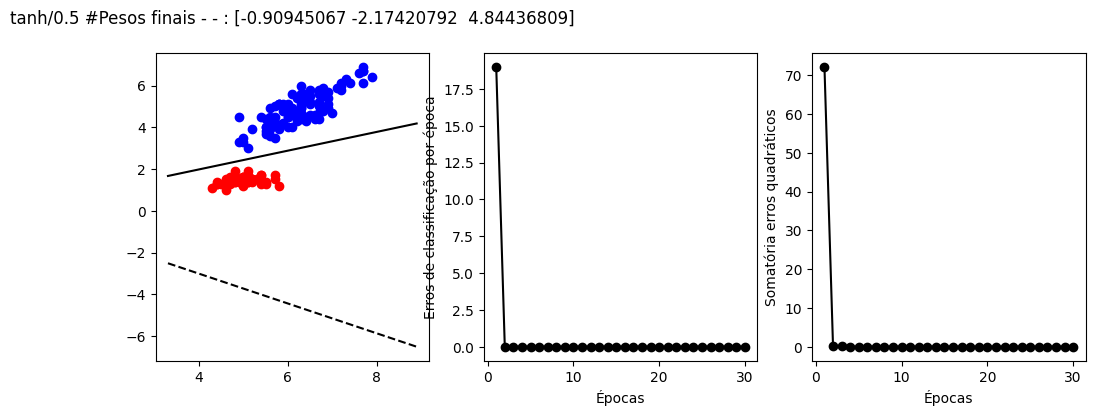

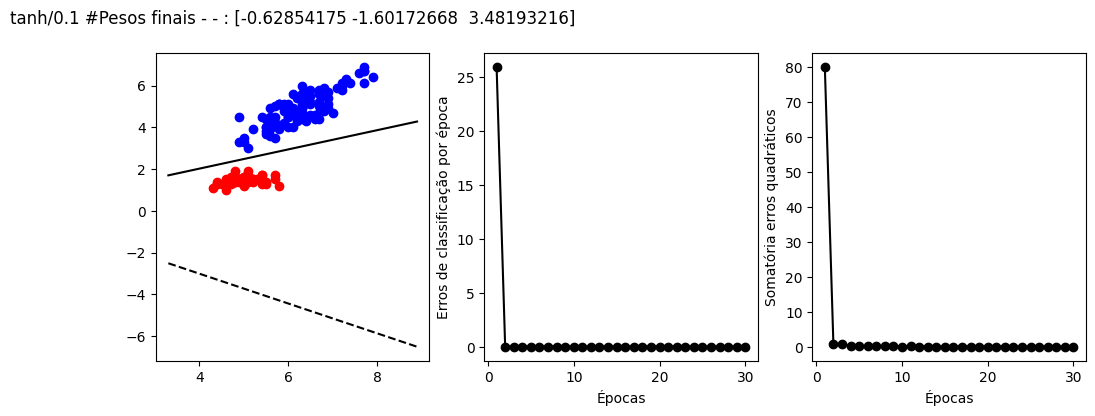

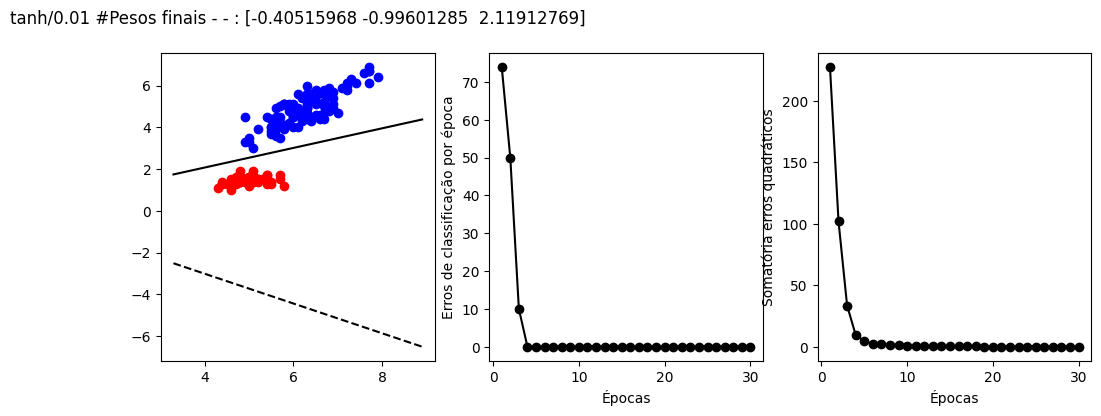

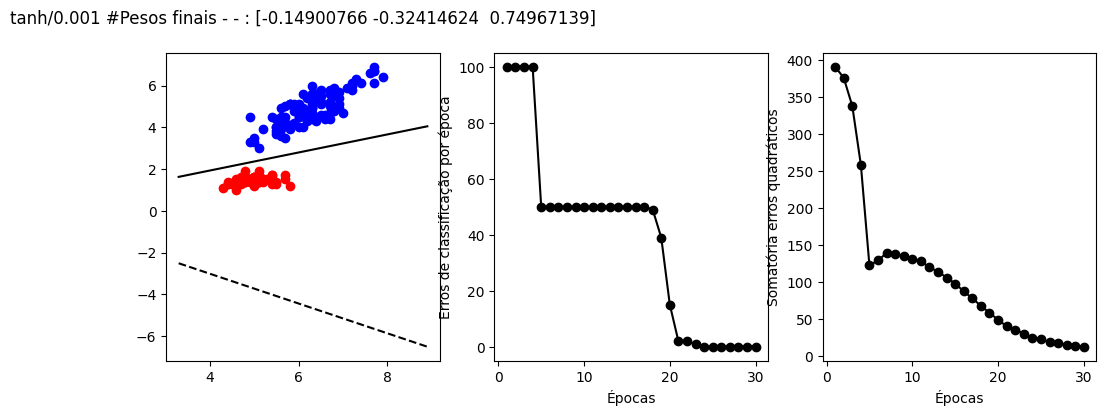

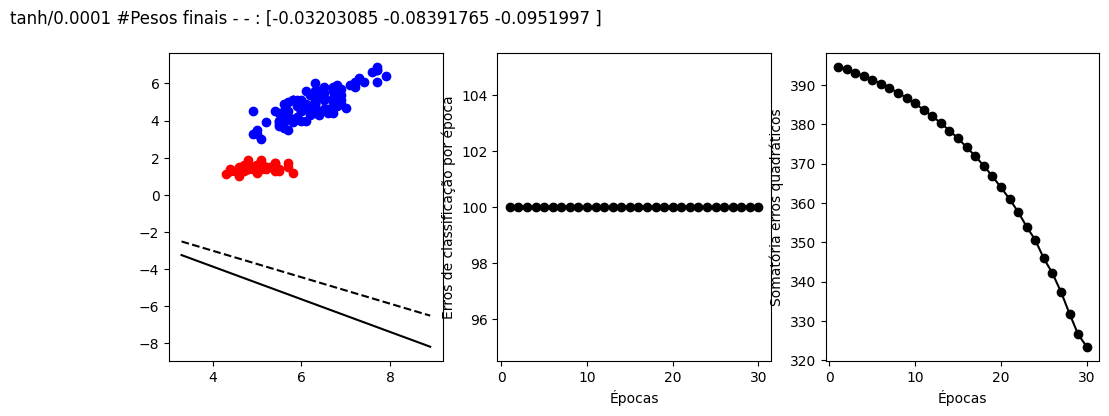

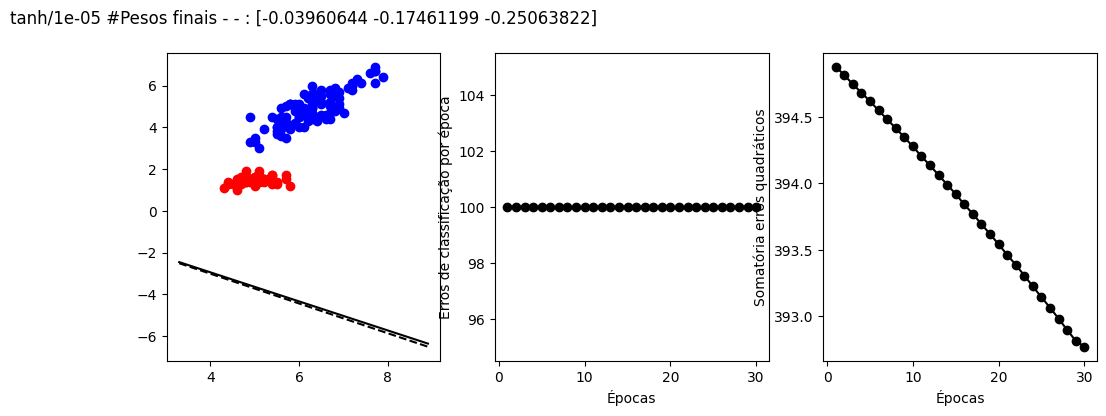

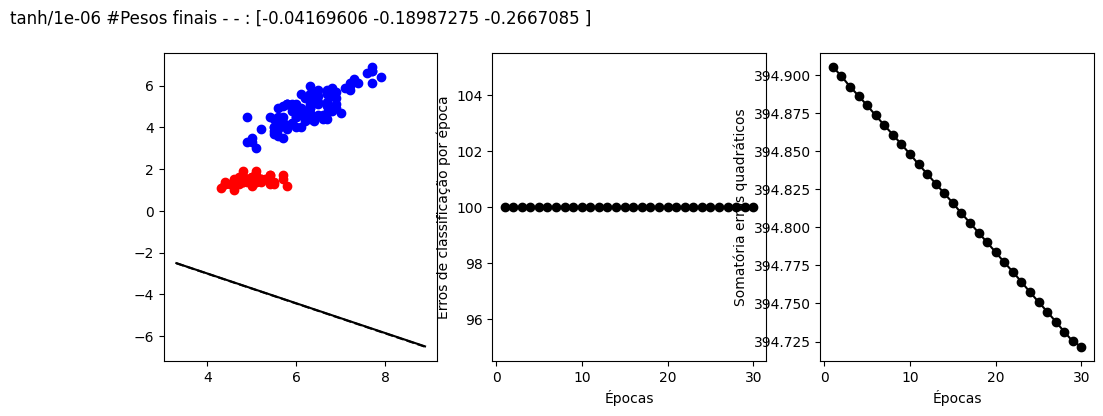

In [17]:
def plota1(rna):
  # base
  x1, y1 = X[y==1,0],X[y==1,1]
  x0, y0 = X[y==-1,0], X[y==-1,1]
  ylim = [min(min(x1) , min(x0))-1, max(max(x0) , max(x1))+1]
  x = np.linspace(ylim[0], ylim[1], 2)

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12, 4))

  # mostra o classificador antes e depois do treinamento
  titulo = f'{rna.fativ}/{rna.eta} #Pesos finais - - : {rna.w_}\n '
  ax1.set_title(titulo)
  ax1.ylim = [min(min(x1) , min(x0))-1, max(max(x0) , max(x1))+1]
  ax1.scatter(x1,y1, color='blue')
  ax1.scatter(x0,y0,color='red')
  ax1.plot(ylim,coord(W0[0],W0[1],W0[2], x),color='black',linestyle='dashed')
  ax1.plot(ylim,coord(rna.w_[0],rna.w_[1],rna.w_[2], x),color='black')

  ax2.plot(range(1, len(rna.erros_classif_)+1), rna.erros_classif_, marker='o',color='black')
  ax2.set_xlabel('Épocas')
  ax2.set_ylabel('Erros de classificação por época')
  # evolução do custo
  ax3.plot(range(1, len(rna.SqError_)+1), rna.SqError_, marker='o', color='black')
  ax3.set_xlabel('Épocas')
  ax3.set_ylabel('Somatória erros quadráticos')

for ind in range(len(classifier_)):
  plota1(classifier_[ind])

- Gradiente Descendente Estocástico (online) x Gradiente Descendente (em lotes)

In [20]:
classifier_ = []
classifierS_ = []
W0_ = []
for eTa in [ 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]:
  # cria objeto
  np.random.seed(35)  # deixar reproduzível
  print(f'eta={eTa}')
  classifierS = Neuronio(fativ='ReLU', eta=eTa, epocas=30,showErro=False)
  np.random.seed(35)  # deixar reproduzível
  classifier = Neuronio(fativ='ReLU', eta=eTa, epocas=30,showErro=False)
  W0 = classifierS.w_.copy()
  W0_.append(W0)
  # treinamento
  np.random.seed(35)
  %time classifier.treinaGD(X,y)
  np.random.seed(35)
  %time classifierS.treinaSGD(X,y)

  classifierS_.append(classifierS)
  classifier_.append(classifier)

eta=0.5
CPU times: total: 0 ns
Wall time: 993 µs
CPU times: total: 78.1 ms
Wall time: 68.6 ms
eta=0.1
CPU times: total: 0 ns
Wall time: 1 ms
CPU times: total: 62.5 ms
Wall time: 60.7 ms
eta=0.01
CPU times: total: 0 ns
Wall time: 1 ms
CPU times: total: 62.5 ms
Wall time: 59.8 ms
eta=0.001
CPU times: total: 0 ns
Wall time: 1.03 ms


C:\Users\gusta\AppData\Local\Temp\ipykernel_15848\1032369459.py:104: RuntimeWarning: overflow encountered in scalar add
  SqError += erro*erro
C:\Users\gusta\AppData\Local\Temp\ipykernel_15848\1032369459.py:104: RuntimeWarning: overflow encountered in scalar multiply
  SqError += erro*erro
C:\Users\gusta\AppData\Local\Temp\ipykernel_15848\1032369459.py:105: RuntimeWarning: invalid value encountered in scalar add
  erro_ep += erro
C:\Users\gusta\AppData\Local\Temp\ipykernel_15848\1032369459.py:112: RuntimeWarning: invalid value encountered in scalar add
  self.w_[0] +=  atualizacao * 1
C:\Users\gusta\AppData\Local\Temp\ipykernel_15848\1032369459.py:113: RuntimeWarning: invalid value encountered in add
  self.w_[1:] +=  atualizacao * xi


CPU times: total: 78.1 ms
Wall time: 70.7 ms
eta=0.0001
CPU times: total: 0 ns
Wall time: 970 µs
CPU times: total: 62.5 ms
Wall time: 61.7 ms
eta=1e-05
CPU times: total: 0 ns
Wall time: 2.05 ms
CPU times: total: 62.5 ms
Wall time: 60.6 ms
eta=1e-06
CPU times: total: 0 ns
Wall time: 1e+03 µs
CPU times: total: 62.5 ms
Wall time: 59.7 ms


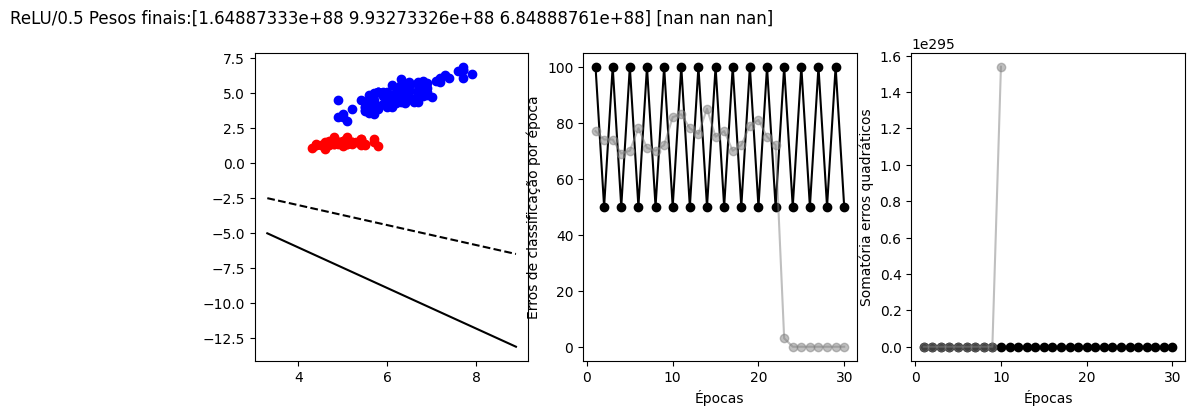

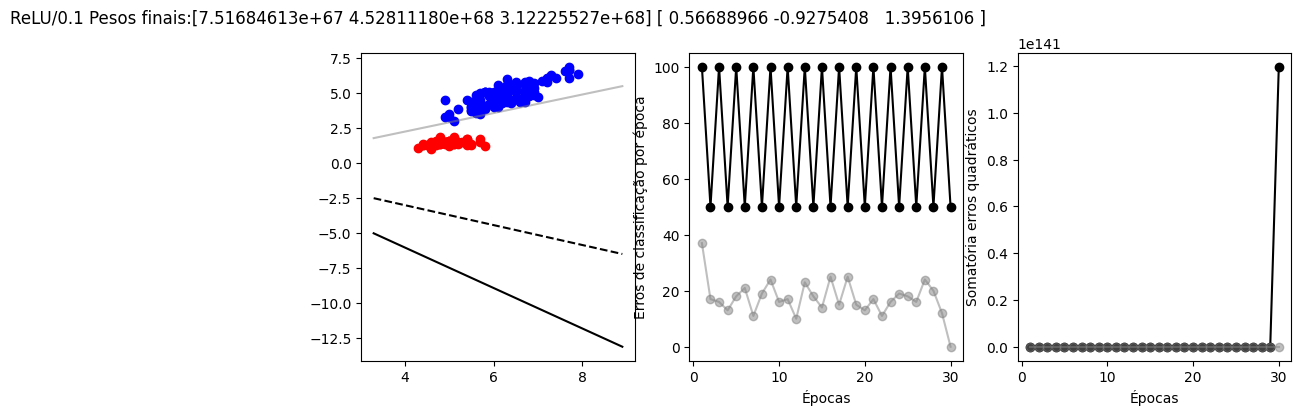

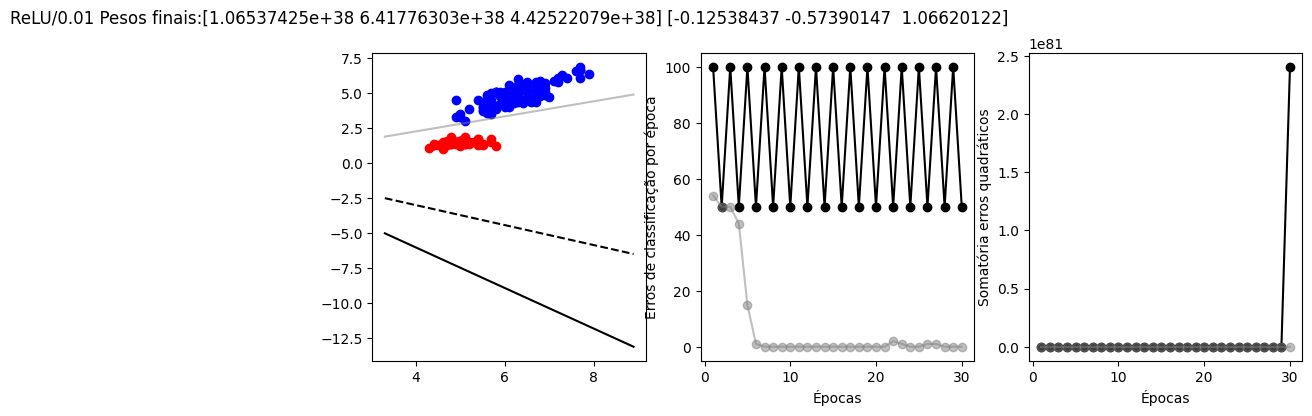

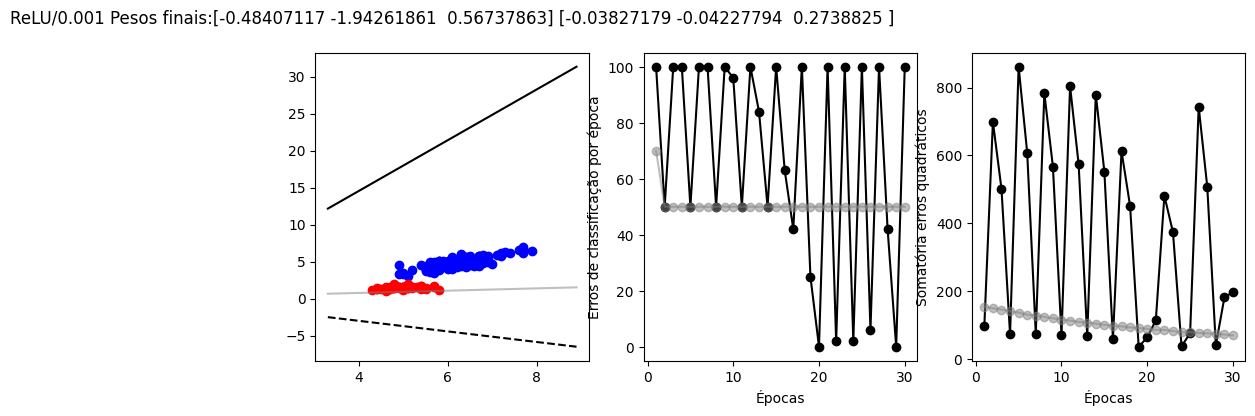

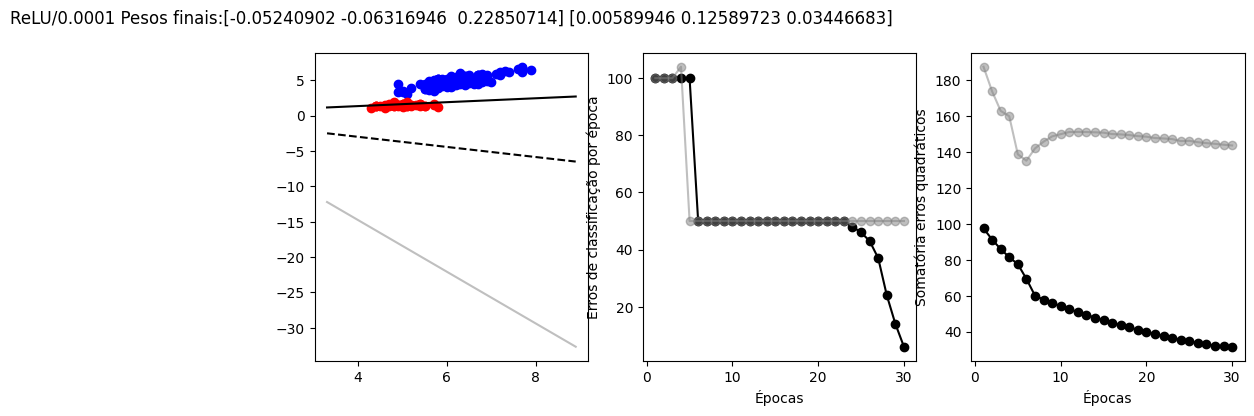

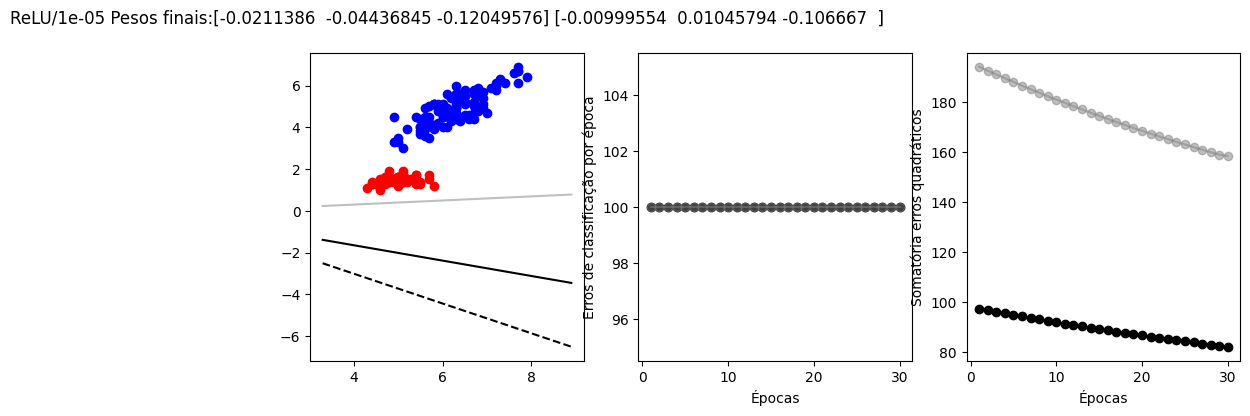

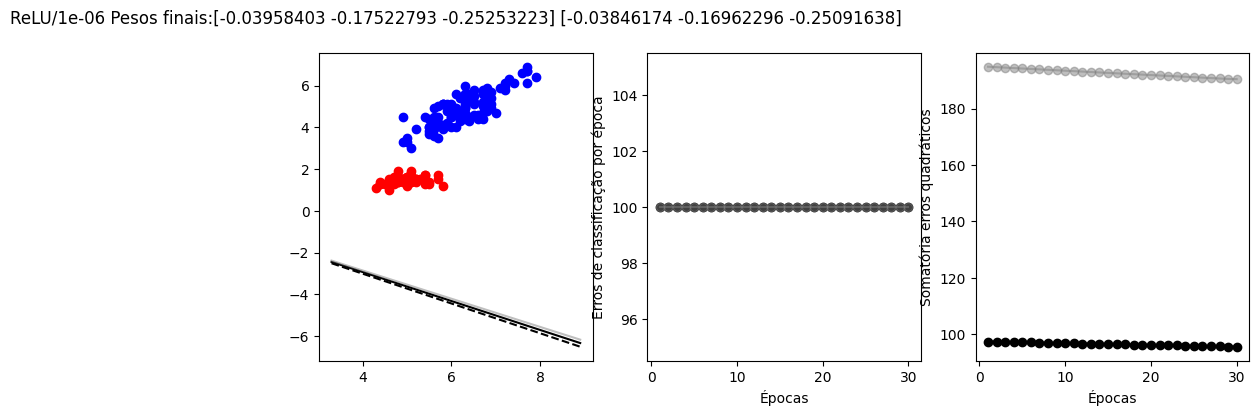

In [21]:
def plota(rna, rna2):
  # base
  x1, y1 = X[y==1,0],X[y==1,1]
  x0, y0 = X[y==-1,0], X[y==-1,1]
  ylim = [min(min(x1) , min(x0))-1, max(max(x0) , max(x1))+1]
  x = np.linspace(ylim[0], ylim[1], 2)

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12, 4))

  # mostra o classificador antes e depois do treinamento
  titulo = f'{rna.fativ}/{rna.eta} Pesos finais:{rna.w_} {rna2.w_}\n'#Pesos iniciais - - : {W0}\n '
  ax1.set_title(titulo)
  ax1.ylim = [min(min(x1) , min(x0))-1, max(max(x0) , max(x1))+1]
  ax1.scatter(x1,y1, color='blue')
  ax1.scatter(x0,y0,color='red')
  ax1.plot(ylim,coord(W0[0],W0[1],W0[2], x),color='black',linestyle='dashed')
  ax1.plot(ylim,coord(rna.w_[0],rna.w_[1],rna.w_[2], x),color='black')
  ax1.plot(ylim,coord(rna2.w_[0],rna2.w_[1],rna2.w_[2], x),color='gray', alpha=0.5)

  ax2.plot(range(1, len(rna.erros_classif_)+1), rna.erros_classif_, marker='o',color='black')
  ax2.plot(range(1, len(rna2.erros_classif_)+1), rna2.erros_classif_, marker='o', color='gray',alpha=0.5)
  ax2.set_xlabel('Épocas')
  ax2.set_ylabel('Erros de classificação por época')
  # evolução do custo
  ax3.plot(range(1, len(rna.SqError_)+1), rna.SqError_, marker='o', color='black')
  ax3.plot(range(1, len(rna2.SqError_)+1), rna2.SqError_, marker='o',color='gray',alpha=0.5)
  ax3.set_xlabel('Épocas')
  ax3.set_ylabel('Somatória erros quadráticos')

for ind in range(len(classifierS_)):
  plota(classifier_[ind],classifierS_[ind])

---------------------------------------------------------

## Atividades

* A função *%time* do notebook

```
%time <comando python>
```
calcula o tempo de execução do comando (pode não ser precisa porque depende dos processos em execução na máquina e este script está sendo executado na nuvem do Google/Colab)

.

O **objetivo principal** destas implementações é que os alunos entendam na prática e, consequentemente, adquiram familiaridade com os conceitos e as características básicas das RNAs.

.


1) Refazer os exemplos do último trabalho usando outras funções de ativação (tanh e ReLU) ... e pensar a respeito: nesse problema, qual foi a melhor? ... como se pode saber qual é mais eficiente? quantidade de épocas necessárias para aprender? tempo de execução?...  

2) Refazer os resultados usando o GD e comparar com o SGD ... nesse problema, qual é mais eficiente? ... vale a pena utilizar valores de eta diferentes para cada estratégia?

3) Testar o aprendizado com parte de dataset e com base em outras características (features / outras colunas do df) das plantas.

4) Selecione as features (colunas) do dataset e os parâmetros do modelo de modo a criar um neurônio que, ao invés de classificar entre os tipos de Iris, estima - por exemplo - o tamanho da pétala coluna[1] do df, dados (como entrada) as colunas [2 e 3]. Aqui o problema deixa de ser de classificação para tornar-se um problema de Regressão.

5) Amplie o exercício anterior usando as colunas [0, 2 e 3] do dataframe para estimar o valor da coluna [1]. Neste exemplo, a entrada terá mais de valores, portanto não poderá ser 'visualizada' no plano cartesiano.





4) Estimação de valor real (regressão)

In [ ]:
# dataset Iris
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

#  somente setosa (50) -
y = df.iloc[0:50, 0].values
#y = np.where(y == 'Iris-setosa', -1, 1)

# seleciona somente duas features (colunas) de entrada: comps sepal e petal [1,2]  //
X = df.iloc[0:50, [1,2]].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=102)

In [ ]:
X_test

In [ ]:
classifier2 = Neuronio(fativ='linear', eta=0.0002, epocas=30,showErro=False)
W0 = classifier2.w_.copy()
%time classifier2.treinaSGD(X_train,y_train)
preds = classifier2.predict(X_test)


In [ ]:
y_test,preds

In [ ]:
rna = classifier2
plt.plot(range(1, len(rna.SqError_)+1), rna.SqError_, marker='o', color='black')
plt.xlabel('Épocas')
plt.ylabel('Somatória erros quadráticos')

In [ ]:
plt.plot(range(1, len(X_test)+1), y_test, marker='o', color='black')
plt.plot(range(1, len(X_test)+1), preds, marker='o',color='gray',alpha=0.5)
plt.xlabel('Épocas')
plt.ylabel('Target-previsões test dataset')

In [ ]:
classifier2 = Neuronio(fativ='linear', eta=0.0002, epocas=2,showErro=False)
classifier2.treinaSGD(X_train,y_train)
preds2 = classifier2.predict(X_test)
# calcula previsões - e compara com target  # a cada 2 épocas
classifier2.treinaSGD(X_train,y_train)
preds4 = classifier2.predict(X_test)
classifier2.treinaSGD(X_train,y_train)
preds6 = classifier2.predict(X_test)


In [ ]:
plt.plot(range(1, len(X_test)+1), y_test, marker='o', color='black')
plt.plot(range(1, len(X_test)+1), preds2, marker='o',color='gray',alpha=0.5)
plt.plot(range(1, len(X_test)+1), preds4, marker='o',color='gray',alpha=0.5)
plt.plot(range(1, len(X_test)+1), preds6, marker='o',color='gray',alpha=0.5)
plt.plot(range(1, len(X_test)+1), preds, marker='o',color='gray',alpha=0.5)
plt.xlabel('Épocas')
plt.ylabel('Target-previsões')

5) Usando mais de 2 entradas - regressão

In [ ]:
# dataset Iris
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

#  somente setosa (50) -
y = df.iloc[0:50, 0].values
#y = np.where(y == 'Iris-setosa', -1, 1)

# seleciona somente duas features (colunas) de entrada: comps sepal e petal [1,2]  //
X = df.iloc[0:50, [1,2,3]].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=102)

In [ ]:
X_train

In [ ]:
classifier3 = Neuronio(fativ='linear', eta=0.0002, epocas=30,showErro=False)
W0 = classifier3.w_.copy()
%time classifier3.treinaSGD(X_train,y_train)
preds3 = classifier3.predict(X_test)

In [ ]:
rna = classifier3
plt.plot(range(1, len(rna.SqError_)+1), rna.SqError_, marker='o', color='black')
plt.xlabel('Épocas')
plt.ylabel('Somatória erros quadráticos')

In [ ]:
plt.plot(range(1, len(X_test)+1), y_test, marker='o', color='black')
plt.plot(range(1, len(X_test)+1), preds, marker='+',color='gray',alpha=0.5)
plt.plot(range(1, len(X_test)+1), preds3, marker='o',color='blue',alpha=0.5)
plt.xlabel('Épocas')
plt.ylabel('Target-previsões')

In [ ]:
classifier3gd = Neuronio(fativ='ReLU', eta=0.0002, epocas=30,showErro=False)
W0 = classifier3gd.w_.copy()
%time classifier3gd.treinaGD(X_train,y_train)
preds3gd = classifier3gd.predict(X_test)

In [ ]:
plt.plot(range(1, len(X_test)+1), y_test, marker='o', color='black')
plt.plot(range(1, len(X_test)+1), preds, marker='+',color='gray',alpha=0.5)
plt.plot(range(1, len(X_test)+1), preds3, marker='o',color='blue',alpha=0.5)
plt.plot(range(1, len(X_test)+1), preds3gd, marker='o',color='red',alpha=0.5)
plt.xlabel('Épocas')
plt.ylabel('Target-previsões')

- usando função de ativação não linear

In [ ]:
# limites dos dados
min(y), max(y)

In [ ]:
# supondo tanh() - limites [-1, +1]
# minimo = 4, maximo = 6
# mesmo intervalo e mins e maxs diferentes
# basta 'somar 5 à saida'
y_train_Norm = y_train - 5
y_test_Norm = y_test - 5

In [ ]:
np.random.seed(35)
classifier4 = Neuronio(fativ='tanh', eta=0.0002, epocas=30,showErro=False)
W0 = classifier4.w_.copy()
%time classifier4.treinaSGD(X_train,y_train_Norm)
preds4 = classifier4.predict(X_test)
preds4 = preds4 + 5

In [ ]:
plt.plot(range(1, len(X_test)+1), y_test, marker='o', color='black')
plt.plot(range(1, len(X_test)+1), preds, marker='+',color='gray',alpha=0.5)
plt.plot(range(1, len(X_test)+1), preds3, marker='o',color='blue',alpha=0.5)
plt.plot(range(1, len(X_test)+1), preds4, marker='o',color='red',alpha=0.5)
plt.xlabel('Épocas')
plt.ylabel('Target-previsões')

In [ ]:
# e caso quisessemos usar a info do tipo da Iris
# dataset Iris
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.head()

In [ ]:
# cria três novas colunas em X com categorias
df = pd.get_dummies(df, columns=[4])
df.columns

In [ ]:
df.head()

In [ ]:
#  all -
y = df.iloc[0:150, 0].values
#y = np.where(y == 'Iris-setosa', -1, 1)

# seleciona todas colunas de entrada: exceto a primeira  //
X = df.iloc[0:150, [1,2,3,4,5,6]].values
X[0:3]

In [ ]:
# limites dos dados
min(y), max(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=102)
# supondo tanh() - limites [-1, +1]
# minimo = 4, maximo = 8
# 2x intervalo e mins e maxs diferentes
# basta 'mult 2 e somar 6 à saida'
y_train_Norm = (y_train - 6)/2
y_test_Norm = (y_test - 6)/2

In [ ]:
np.random.seed(35)
classifier5 = Neuronio(fativ='tanh', eta=0.0002, epocas=30,showErro=False)
W0 = classifier5.w_.copy()
%time classifier5.treinaSGD(X_train,y_train_Norm)
preds5 = classifier5.predict(X_test)
preds5 = 2 * (preds5) + 6

In [ ]:
plt.plot(range(1, len(X_test)+1), y_test, marker='o', color='black')
plt.plot(range(1, len(X_test)+1), preds5, marker='+',color='gray',alpha=0.5)
plt.xlabel('Épocas')
plt.ylabel('Target-previsões')